<a href="https://colab.research.google.com/github/XqsZX/face_liveness_detection/blob/master/face_liveness_detection_bagging_trial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 导入包
该os软件包用于读取文件和目录结构，NumPy用于将python列表转换为numpy数组，并执行所需的矩阵运算，matplotlib.pyplot并在训练和验证数据中绘制图形并显示图像。导入Tensorflow和构建模型所需的Keras类。

In [1]:
import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import os
import numpy as np
import matplotlib.pyplot as plt

# 载入资料
本次实验直接采用真实人脸和照片人脸直接进行CNN卷积，只是一次尝试。
首先我们登录谷歌云盘，来导入数据

In [2]:
import os
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


对数据进行导入

In [3]:
PATH = os.path.join('/content/drive/My Drive/', 'data')
PATH_1 = os.path.join('/content/drive/My Drive/', 'data_1')
PATH_2 = os.path.join('/content/drive/My Drive/', 'data_2')

**数据集具有以下目录结构：**
```cats_and_dogs_filtered
|__ train
    |______ real: []
    |______ fake: []
|__ validation
    |______ real: []
    |______ fake: []
```
提取其内容后，为变量分配适当的文件路径以用于训练和验证集。


In [4]:
train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')

train_real_dir = os.path.join(train_dir, 'real')  # directory with our training real pictures
train_fake_dir = os.path.join(train_dir, 'fake')  # directory with our training fake pictures

validation_real_dir = os.path.join(validation_dir, 'real')  # directory with our validation real pictures
validation_fake_dir = os.path.join(validation_dir, 'fake')  # directory with our validation fake pictures

In [ ]:
train_dir_1 = os.path.join(PATH_1, 'train')
validation_dir_1 = os.path.join(PATH_1, 'validation')

train_real_dir_1 = os.path.join(train_dir_1, 'real')  # directory with our training real pictures
train_fake_dir_1 = os.path.join(train_dir_1, 'fake')  # directory with our training fake pictures

validation_real_dir_1 = os.path.join(validation_dir_1, 'real')  # directory with our validation real pictures
validation_fake_dir_1 = os.path.join(validation_dir_1, 'fake')  # directory with our validation fake pictures

In [ ]:
train_dir_2 = os.path.join(PATH_2, 'train')
validation_dir_2 = os.path.join(PATH_2, 'validation')

train_real_dir_2 = os.path.join(train_dir_2, 'real')  # directory with our training real pictures
train_fake_dir_2 = os.path.join(train_dir_2, 'fake')  # directory with our training fake pictures

validation_real_dir_2 = os.path.join(validation_dir_2, 'real')  # directory with our validation real pictures
validation_fake_dir_2 = os.path.join(validation_dir_2, 'fake')  # directory with our validation fake pictures

# 了解数据
让我们看看训练和验证目录中有多少真实和虚假的图像：

In [6]:
num_real_tr = len(os.listdir(train_real_dir))
num_fake_tr = len(os.listdir(train_fake_dir))

num_real_val = len(os.listdir(validation_real_dir))
num_fake_val = len(os.listdir(validation_fake_dir))

total_train = num_real_tr + num_fake_tr
total_val = num_real_val + num_fake_val

print('total training real images:', num_real_tr)
print('total training fake images:', num_fake_tr)

print('total validation real images:', num_real_val)
print('total validation fake images:', num_fake_val)
print("--")
print("Total training images:", total_train)
print("Total validation images:", total_val)

total training real images: 3128
total training fake images: 5293
total validation real images: 1987
total validation fake images: 2216
--
Total training images: 8421
Total validation images: 4203


In [ ]:
num_real_tr_1 = len(os.listdir(train_real_dir_1))
num_fake_tr_1 = len(os.listdir(train_fake_dir_1))

num_real_val_1 = len(os.listdir(validation_real_dir_1))
num_fake_val_1 = len(os.listdir(validation_fake_dir_1))

total_train_1 = num_real_tr_1 + num_fake_tr_1
total_val_1 = num_real_val_1 + num_fake_val_1

print('total training real images of 1:', num_real_tr_1)
print('total training fake images of 1:', num_fake_tr_1)

print('total validation real images of 1:', num_real_val_1)
print('total validation fake images of 1:', num_fake_val_1)
print("--")
print("Total training images of 1:", total_train_1)
print("Total validation images of 1:", total_val_1)

In [ ]:
num_real_tr_2 = len(os.listdir(train_real_dir_2))
num_fake_tr_2 = len(os.listdir(train_fake_dir_2))

num_real_val_2 = len(os.listdir(validation_real_dir_2))
num_fake_val_2 = len(os.listdir(validation_fake_dir_2))

total_train_2 = num_real_tr_2 + num_fake_tr_2
total_val_2 = num_real_val_2 + num_fake_val_2

print('total training real images of 2:', num_real_tr_2)
print('total training fake images of 2:', num_fake_tr_2)

print('total validation real images of 2:', num_real_val_2)
print('total validation fake images of 2:', num_fake_val_2)
print("--")
print("Total training images of 2:", total_train_2)
print("Total validation images of 2:", total_val_2)

为了方便起见，设置变量以在预处理数据集和训练网络时使用。

In [7]:
batch_size = 128
epochs = 15
IMG_HEIGHT = 150
IMG_WIDTH = 150

# 资料准备
将图像格式化为经过适当预处理的浮点张量，然后再馈入网络：

1. 从磁盘读取图像
2. 解码这些图像的内同，并根据其RGB内容将其转换为正确的网格格式
3. 将它们转换为浮点张量
4. 将张量从0到255之间的值重新缩放为0到1之间的值，因为神经网络更喜欢处理较小的输入值


解码这些图像的内容，并根据其RGB内容将其转换为正确的网格格式。
将它们转换为浮点张量。
将张量从0到255之间的值重新缩放为0到1之间的值，因为神经网络更喜欢处理较小的输入值。
幸运的是，所有这些任务都可以通过提供的ImageDataGenerator类来完成tf.keras。它可以从磁盘读取图像并将其预处理为适当的张量。它还将设置将这些图像转换成张量的生成器，这对于训练网络很有帮助。

训练量很少时，通常会发生过度拟合。解决此问题的一种方法是扩充数据集，使其具有足够数量的训练示例。数据增强采用通过使用产生真实感图像的随机变换增强样本来从现有训练样本生成更多训练数据的方法。目标是模型在训练期间永远不会看到两次完全相同的图片。这有助于使模型暴露于数据的更多方面，并且可以更好地进行概括。

tf.keras使用ImageDataGenerator类来实现这一点。将不同的转换传递给数据集，它将在训练过程中加以应用。
对训练图像进行重新缩放，45度旋转，宽度偏移，高度偏移，水平翻转和缩放增强。防止出现过拟合的情况

In [8]:
image_gen_train = ImageDataGenerator(rescale=1./255,rotation_range=45,width_shift_range=.15,height_shift_range=.15,horizontal_flip=True,zoom_range=0.5)
train_data_gen = image_gen_train.flow_from_directory(batch_size=batch_size,directory=train_dir,shuffle=True,target_size=(IMG_HEIGHT, IMG_WIDTH),class_mode='binary')

Found 8421 images belonging to 2 classes.


In [ ]:
train_data_gen_1 = image_gen_train.flow_from_directory(batch_size=batch_size,directory=train_dir_1,shuffle=True,target_size=(IMG_HEIGHT, IMG_WIDTH),class_mode='binary')

Found 8421 images belonging to 2 classes.


In [ ]:
train_data_gen_2 = image_gen_train.flow_from_directory(batch_size=batch_size,directory=train_dir_2,shuffle=True,target_size=(IMG_HEIGHT, IMG_WIDTH),class_mode='binary')

Found 8421 images belonging to 2 classes.


**创建验证数据生成器**

通常，仅将数据扩充应用于训练示例。在这种情况下，仅重新缩放验证图像，然后使用将它们转换为批次ImageDataGenerator。

In [9]:
image_gen_val = ImageDataGenerator(rescale=1./255)
val_data_gen = image_gen_val.flow_from_directory(batch_size=batch_size,directory=validation_dir,target_size=(IMG_HEIGHT, IMG_WIDTH),class_mode='binary')

Found 4203 images belonging to 2 classes.


In [ ]:
val_data_gen_1 = image_gen_val.flow_from_directory(batch_size=batch_size,directory=validation_dir_1,target_size=(IMG_HEIGHT, IMG_WIDTH),class_mode='binary')

In [ ]:
val_data_gen_2 = image_gen_val.flow_from_directory(batch_size=batch_size,directory=validation_dir_2,target_size=(IMG_HEIGHT, IMG_WIDTH),class_mode='binary')

# 构建神经网络
减少过度拟合的另一种技术是将丢失引入网络。这是一种正则化形式，它迫使网络中的权重仅取较小的值，这使得权重值的分配更加规则，并且网络可以减少在小的训练样本上的过度拟合。

当您在图层上应用滤除时，它会在训练过程中从所应用的图层中随机滤除（设置为零）数量的输出单位。dropout采用分数形式作为其输入值，形式为0.1、0.2、0.4等。这意味着从所施加的层中随机退出输出单元的10％，20％或40％。将0.1的dropout应用于某个图层时，它会在每个训练时期随机杀死10％的输出单位。使用此新的dropout功能创建网络体系结构，并将其应用于不同的卷积和完全连接的层。

In [10]:
model = Sequential([
    Conv2D(16, 3, padding='same', activation='relu', 
           input_shape=(IMG_HEIGHT, IMG_WIDTH ,3)),
    MaxPooling2D(),
    Dropout(0.2),
    Conv2D(32, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Conv2D(64, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Dropout(0.2),
    Flatten(),
    Dense(512, activation='relu'),
    Dense(1)
])

In [ ]:
model_1 = Sequential([
    Conv2D(16, 3, padding='same', activation='relu', 
           input_shape=(IMG_HEIGHT, IMG_WIDTH ,3)),
    MaxPooling2D(),
    Dropout(0.2),
    Conv2D(32, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Conv2D(64, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Dropout(0.2),
    Flatten(),
    Dense(512, activation='relu'),
    Dense(1)
])

In [ ]:
model_2 = Sequential([
    Conv2D(16, 3, padding='same', activation='relu', 
           input_shape=(IMG_HEIGHT, IMG_WIDTH ,3)),
    MaxPooling2D(),
    Dropout(0.2),
    Conv2D(32, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Conv2D(64, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Dropout(0.2),
    Flatten(),
    Dense(512, activation='relu'),
    Dense(1)
])

# 编译模型
将dropout引入网络后，编译模型并查看图层摘要。

In [11]:
model.compile(optimizer='adam',loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 150, 150, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 75, 75, 16)        0         
_________________________________________________________________
dropout (Dropout)            (None, 75, 75, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 75, 75, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 37, 37, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 37, 37, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 18, 18, 64)        0

In [ ]:
model_1.compile(optimizer='adam',loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),metrics=['accuracy'])
model_1.summary()

In [ ]:
model_2.compile(optimizer='adam',loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),metrics=['accuracy'])
model_2.summary()

# 训练模型
在将数据扩充成功地引入到训练示例并向网络中添加了dropout之后，训练这个新网络：

In [12]:
trained_model = model.fit_generator(
    train_data_gen,
    steps_per_epoch=total_train // batch_size,
    epochs=epochs,
    validation_data=val_data_gen,
    validation_steps=total_val // batch_size
)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/15
65/65 [==============================] - 3719s 57s/step - loss: 0.6812 - accuracy: 0.6830 - val_loss: 0.9281 - val_accuracy: 0.5532
Epoch 2/15
65/65 [==============================] - 61s 936ms/step - loss: 0.2413 - accuracy: 0.8928 - val_loss: 1.0604 - val_accuracy: 0.6494
Epoch 3/15
65/65 [==============================] - 61s 937ms/step - loss: 0.1075 - accuracy: 0.9563 - val_loss: 1.1636 - val_accuracy: 0.6909
Epoch 4/15
65/65 [==============================] - 61s 942ms/step - loss: 0.0735 - accuracy: 0.9701 - val_loss: 1.4261 - val_accuracy: 0.7224
Epoch 5/15
65/65 [==============================] - 61s 938ms/step - loss: 0.0686 - accuracy: 0.9726 - val_loss: 1.0167 - val_accuracy: 0.7124
Epoch 6/15
65/65 [==============================] - 62s 958ms/step - loss: 0.0572 - accuracy: 0.9790 - val_loss: 0.9196 - val_accuracy: 0.8342
Epoch 7/15
65/65 [==============================] - 62s 949ms/step

In [ ]:
trained_model_1 = model_1.fit_generator(
    train_data_gen_1,
    steps_per_epoch=total_train_1 // batch_size,
    epochs=epochs,
    validation_data=val_data_gen_1,
    validation_steps=total_val_1 // batch_size
)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/15
65/65 [==============================] - 3719s 57s/step - loss: 0.6812 - accuracy: 0.6830 - val_loss: 0.9281 - val_accuracy: 0.5532
Epoch 2/15
65/65 [==============================] - 61s 936ms/step - loss: 0.2413 - accuracy: 0.8928 - val_loss: 1.0604 - val_accuracy: 0.6494
Epoch 3/15
65/65 [==============================] - 61s 937ms/step - loss: 0.1075 - accuracy: 0.9563 - val_loss: 1.1636 - val_accuracy: 0.6909
Epoch 4/15
65/65 [==============================] - 61s 942ms/step - loss: 0.0735 - accuracy: 0.9701 - val_loss: 1.4261 - val_accuracy: 0.7224
Epoch 5/15
65/65 [==============================] - 61s 938ms/step - loss: 0.0686 - accuracy: 0.9726 - val_loss: 1.0167 - val_accuracy: 0.7124
Epoch 6/15
65/65 [==============================] - 62s 958ms/step - loss: 0.0572 - accuracy: 0.9790 - val_loss: 0.9196 - val_accuracy: 0.8342
Epoch 7/15
65/65 [==============================] - 62s 949ms/step

In [ ]:
trained_model_2 = model_2.fit_generator(
    train_data_gen_2,
    steps_per_epoch=total_train_2 // batch_size,
    epochs=epochs,
    validation_data=val_data_gen_2,
    validation_steps=total_val_2 // batch_size
)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/15
65/65 [==============================] - 3719s 57s/step - loss: 0.6812 - accuracy: 0.6830 - val_loss: 0.9281 - val_accuracy: 0.5532
Epoch 2/15
65/65 [==============================] - 61s 936ms/step - loss: 0.2413 - accuracy: 0.8928 - val_loss: 1.0604 - val_accuracy: 0.6494
Epoch 3/15
65/65 [==============================] - 61s 937ms/step - loss: 0.1075 - accuracy: 0.9563 - val_loss: 1.1636 - val_accuracy: 0.6909
Epoch 4/15
65/65 [==============================] - 61s 942ms/step - loss: 0.0735 - accuracy: 0.9701 - val_loss: 1.4261 - val_accuracy: 0.7224
Epoch 5/15
65/65 [==============================] - 61s 938ms/step - loss: 0.0686 - accuracy: 0.9726 - val_loss: 1.0167 - val_accuracy: 0.7124
Epoch 6/15
65/65 [==============================] - 62s 958ms/step - loss: 0.0572 - accuracy: 0.9790 - val_loss: 0.9196 - val_accuracy: 0.8342
Epoch 7/15
65/65 [==============================] - 62s 949ms/step

# 可视化模型
训练后可视化新模型，训练模型更多的时间后，准确性提高

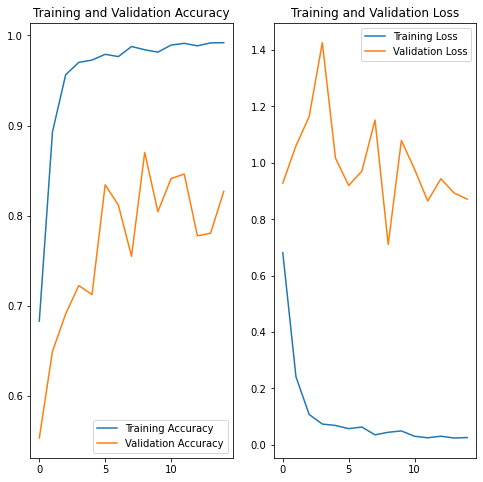

In [13]:
acc = trained_model.history['accuracy']
val_acc = trained_model.history['val_accuracy']

loss = trained_model.history['loss']
val_loss = trained_model.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

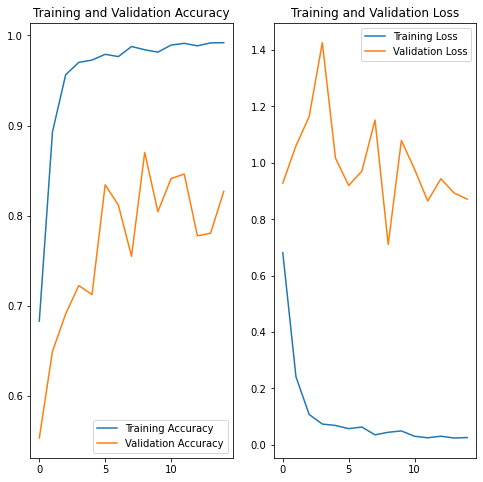

In [ ]:
acc_1 = trained_model_1.history['accuracy']
val_acc_1 = trained_model_1.history['val_accuracy']

loss_1 = trained_model_1.history['loss']
val_loss_1 = trained_model_1.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc_1, label='Training Accuracy of 1')
plt.plot(epochs_range, val_acc_1, label='Validation Accuracy of 1')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy of 1')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss_1, label='Training Loss of 1')
plt.plot(epochs_range, val_loss_1, label='Validation Loss of 1')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss of 1')
plt.show()

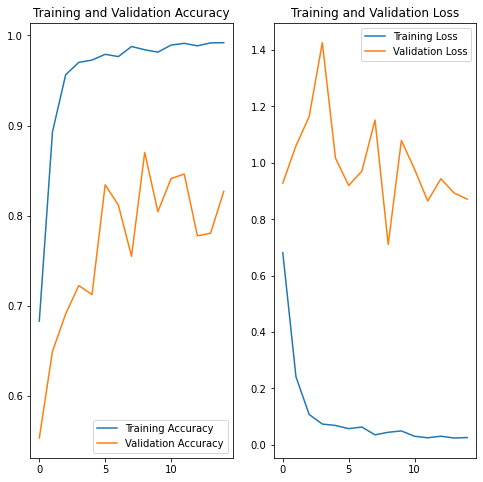

In [ ]:
acc_2 = trained_model_2.history['accuracy']
val_acc_2 = trained_model_2.history['val_accuracy']

loss_2 = trained_model_2.history['loss']
val_loss_2 = trained_model_2.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc_2, label='Training Accuracy of 2')
plt.plot(epochs_range, val_acc_2, label='Validation Accuracy of 2')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy of 2')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss_2, label='Training Loss of 2')
plt.plot(epochs_range, val_loss_2, label='Validation Loss of 2')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss of 2')
plt.show()

# 对新数据进行预测
最后，让我们使用训练出来的数据对新数据进行预测

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

count_real = 0
count_fake = 0

test_PATH = "/content/drive/My Drive/dataset/train/fake/5217.jpg"
path = "/content/drive/My Drive/dataset/train/fake"
os.chdir(path)
os.listdir(path)

img = Image.open("5217.jpg")
print(img.mode)
plt.figure("img")
plt.imshow(img)
plt.show()

img = keras.preprocessing.image.load_img(
    test_PATH, target_size=(img_height, img_width)
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
predictions_1 = model_1.predict(img_array)
predictions_2 = model_2.predict(img_array)

if predictions == 'real':
  count_real = count_real + 1
else:
  count_fake = count_fake + 1

if predictions_1 == 'real':
  count_real = count_real + 1
else:
  count_fake = count_fake + 1

if predictions_2 == 'real':
  count_real = count_real + 1
else:
  count_fake = count_fake + 1

if count_real > count_fake:
  print("this face is real")
else:
  print("this face is fake")